本节将讨论优化与深度学习的关系，以及优化在深度学习中的挑战。在一个深度学习问题中，**我们通常会预先定义一个损失函数**。有了损失函数以后，我们就可以使用优化算法试图将其最小化。在优化中，这样的损失函数通常被称作优化问题的目标函数（objective function）。**依据惯例，优化算法通常只考虑最小化目标函数**。其实，任何最大化问题都可以很容易地转化为最小化问题，只需令目标函数的相反数为新的目标函数即可。

## 7.1.1 优化与深度学习的关系

虽然优化为深度学习提供了最小化损失函数的方法，但本质上，优化与深度学习的目标是有区别的。
在3.11节（模型选择、欠拟合和过拟合）中，我们区分了训练误差和泛化误差。
由于优化算法的目标函数通常是一个基于训练数据集的损失函数，**优化的目标在于降低训练误差**。
而**深度学习的目标在于降低泛化误差**。为了降低泛化误差，除了使用优化算法降低训练误差以外，还需要注意应对过拟合。

本章中，我们只关注优化算法在最小化目标函数上的表现，而不关注模型的泛化误差。

## 7.1.2 优化在深度学习中的挑战

我们在3.1节（线性回归）中对优化问题的解析解和数值解做了区分。深度学习中绝大多数目标函数都很复杂。因此，**很多优化问题并不存在解析解**，而**需要使用基于数值方法的优化算法找到近似解**，即数值解。**本书中讨论的优化算法都是这类基于数值方法的算法**。为了求得最小化目标函数的数值解，我们将通过优化算法**有限次迭代模型参数**来**尽可能降低损失函数的值**。

优化在深度学习中有很多挑战。下面描述了其中的两个挑战，即**局部最小值**和**鞍点**。为了更好地描述问题，我们先导入本节中实验需要的包或模块。

In [1]:
%matplotlib inline
import sys
import tensorflow as tf
sys.path.append("..") 
import d2lzh_tensorflow2 as d2l
from mpl_toolkits import mplot3d # 三维画图
import numpy as np

### 7.1.2.1 局部最小值

对于目标函数$f(x)$，如果$f(x)$在$x$上的值比在$x$邻近的其他点的值更小，那么$f(x)$可能是一个局部最小值（local minimum）。如果$f(x)$在$x$上的值是目标函数在整个定义域上的最小值，那么$f(x)$是全局最小值（global minimum）。

举个例子，给定函数

$$
f(x) = x \cdot \text{cos}(\pi x), \qquad -1.0 \leq x \leq 2.0,
$$

我们可以大致找出该函数的局部最小值和全局最小值的位置。需要注意的是，图中箭头所指示的只是大致位置。

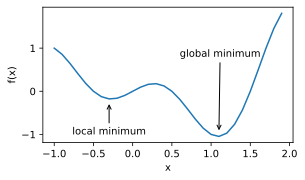

In [2]:
def f(x):
    return x * np.cos(np.pi * x)

d2l.set_figsize((4.5, 2.5))
x = np.arange(-1.0, 2.0, 0.1)
fig,  = d2l.plt.plot(x, f(x))
fig.axes.annotate('local minimum', xy=(-0.3, -0.25), xytext=(-0.77, -1.0),
                  arrowprops=dict(arrowstyle='->'))
fig.axes.annotate('global minimum', xy=(1.1, -0.95), xytext=(0.6, 0.8),
                  arrowprops=dict(arrowstyle='->'))
d2l.plt.xlabel('x')
d2l.plt.ylabel('f(x)');

深度学习模型的目标函数可能有若干局部最优值。当一个优化问题的数值解在局部最优解附近时，由于目标函数有关解的梯度接近或变成零，**最终迭代求得的数值解可能只令目标函数局部最小化而非全局最小化**。

### 7.1.2.2 鞍点

刚刚我们提到，梯度接近或变成零可能是由于当前解在局部最优解附近造成的。事实上，**另一种可能性是当前解在鞍点（saddle point）附近。**

举个例子，给定函数

$$f(x) = x^3,$$

我们可以找出该函数的鞍点位置。

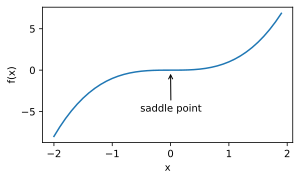

In [3]:
x = np.arange(-2.0, 2.0, 0.1)
fig, = d2l.plt.plot(x, x**3)
fig.axes.annotate('saddle point', xy=(0, -0.2), xytext=(-0.52, -5.0),
                  arrowprops=dict(arrowstyle='->'))
d2l.plt.xlabel('x')
d2l.plt.ylabel('f(x)');

再举个定义在二维空间的函数的例子，例如：

$$f(x, y) = x^2 - y^2.$$

我们可以找出该函数的鞍点位置。也许你已经发现了，该函数看起来像一个马鞍，而鞍点恰好是马鞍上可坐区域的中心。

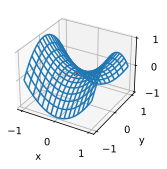

In [4]:
x, y = np.mgrid[-1: 1: 31j, -1: 1: 31j]
z = x**2 - y**2

ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 2, 'cstride': 2})
ax.plot([0], [0], [0], 'rx')
ticks = [-1,  0, 1]
d2l.plt.xticks(ticks)
d2l.plt.yticks(ticks)
ax.set_zticks(ticks)
d2l.plt.xlabel('x')
d2l.plt.ylabel('y');

在图的鞍点位置，目标函数在$x$轴方向上是局部最小值，但在$y$轴方向上是局部最大值。

假设一个函数的输入为$k$维向量，输出为标量，那么它的海森矩阵（Hessian matrix）有$k$个特征值。该函数在梯度为0的位置上可能是局部最小值、局部最大值或者鞍点。

* 当函数的海森矩阵**在梯度为零的位置上的特征值全为正时**，该函数得到**局部最小值**。
* 当函数的海森矩阵**在梯度为零的位置上的特征值全为负时**，该函数得到**局部最大值**。
* 当函数的海森矩阵**在梯度为零的位置上的特征值有正有负时**，该函数得到鞍点。

随机矩阵理论告诉我们，对于一个大的高斯随机矩阵来说，任一特征值是正或者是负的概率都是0.5 [1]。那么，以上第一种情况的概率为 $0.5^k$。由于深度学习模型参数通常都是高维的（$k$很大），目标函数的鞍点通常比局部最小值更常见。

在深度学习中，虽然找到目标函数的全局最优解很难，但这并非必要。我们将在本章接下来的几节中**逐一介绍深度学习中常用的优化算法**，它们在很多实际问题中都能够训练出十分有效的深度学习模型。

## 小结

* 由于优化算法的目标函数通常是一个基于训练数据集的损失函数，优化的目标在于降低训练误差。
* 由于深度学习模型参数通常都是高维的，目标函数的鞍点通常比局部最小值更常见。


## 参考文献

[1] Wigner, E. P. (1958). On the distribution of the roots of certain symmetric matrices. Annals of Mathematics, 325-327.

------------

> 注：本节与原书基本相同，[原书传送门](https://zh.d2l.ai/chapter_optimization/optimization-intro.html)

